In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID


In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.base import load_dataset
from ganime.utils.statistics import dataset_statistics
from ganime.model.vqgan_clean.vqgan import VQGAN
from ganime.visualization.videos import display_images, display_videos
import tensorflow as tf
from datetime import datetime
from tqdm import tqdm
from pyprojroot.pyprojroot import here
#tf.get_logger().setLevel('ERROR')

In [8]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [9]:
num_workers = len(tf.config.list_physical_devices("GPU"))
batch_size = 128

In [33]:
cfg = omegaconf.OmegaConf.load(here("configs/default.yaml"))

In [12]:
logdir = "../../../logs/ganime/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [13]:
#train_ds, test_ds, input_shape = load_dataset("kny_images", "../../../data", batch_size=128)

In [14]:
from tensorflow.keras.utils import Sequence
import numpy as np
import skvideo.io
import os
from skimage.transform import resize
import math

class KNYImages(Sequence):

    def __init__(self, dataset_path: str, batch_size: int, split="train"):
        self.data = np.load(os.path.join(dataset_path, "kny", "kny_images_64x128.npy"))
        if split == "train":
            self.data = self.data[:-5000]
        else:
            self.data = self.data[-5000:]
            
        self.data = self.data / 255
        self.batch_size = batch_size
        self.indices = np.arange(self.data.shape[0])
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = self.data[inds]
        batch_y = batch_x

        return batch_x, batch_y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [15]:
train_ds = KNYImages("../../../data", batch_size=batch_size, split="train")

In [16]:
test_ds = KNYImages("../../../data", batch_size=batch_size, split="test")

In [17]:

import io
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

class TensorBoardImage(tf.keras.callbacks.Callback):

    def __init__(self, logdir, train, validation=None):
        super(TensorBoardImage, self).__init__()
        self.logdir = logdir
        self.train = train
        self.validation = validation
        self.file_writer = tf.summary.create_file_writer(logdir)

    def on_epoch_end(self, epoch, logs):
        train_imgs = self.train[0][0]
        val_imgs = self.validation[0][0][:10]

        train_pred = self.model.predict(train_imgs)
        validation_pred = self.model.predict(val_imgs)

        with self.file_writer.as_default():
            tf.summary.image("Training data", plot_to_image(display_images(train_pred)), step=epoch)
            tf.summary.image("Validation data", plot_to_image(display_images(validation_pred)), step=epoch)

tensorboard_image_callback = TensorBoardImage(logdir=logdir, train=train_ds, validation=test_ds)

2022-05-23 07:40:38.029668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-23 07:40:40.868204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14252 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-05-23 07:40:40.869275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14252 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:25:00.0, compute capability: 8.6
2022-05-23 07:40:40.870155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

In [18]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [19]:
train_mean, train_var, train_std = dataset_statistics(train_ds)

  0%|          | 0/227 [00:00<?, ?it/s]

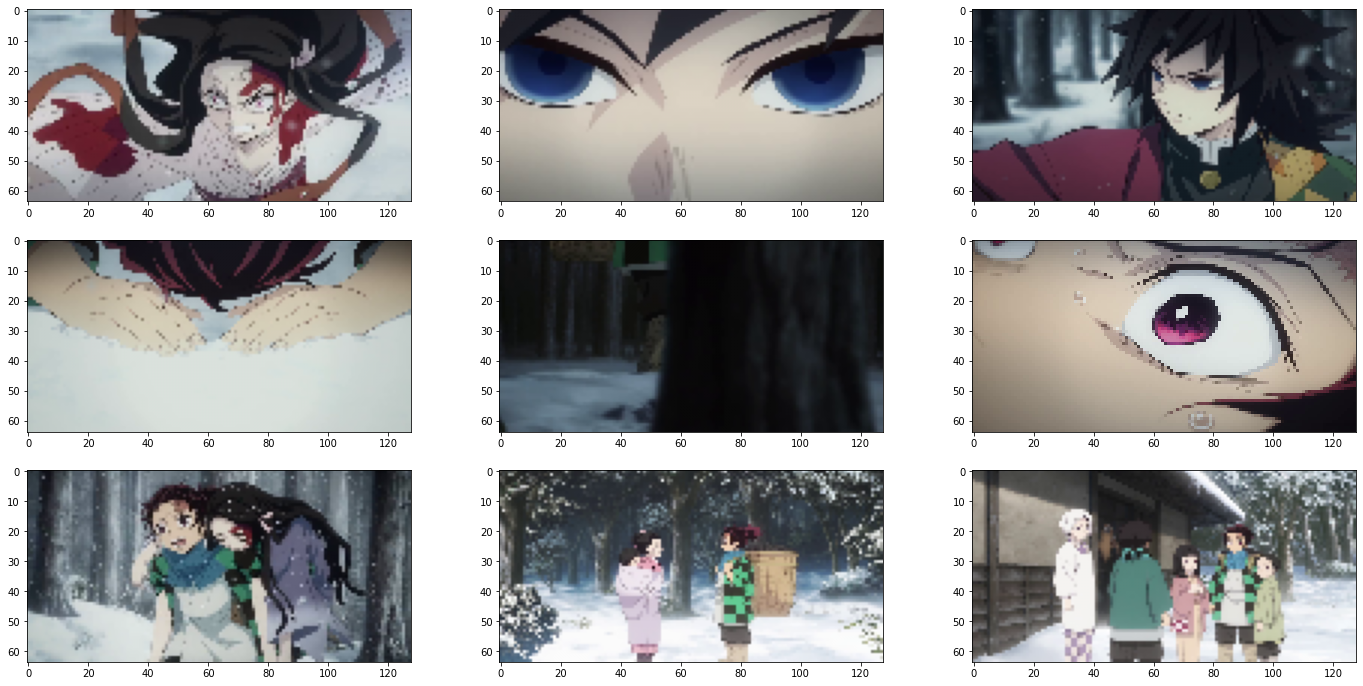

In [20]:
display_images(train_ds[100][0])
plt.show()

In [21]:
#with strategy.scope():
#    vqgan = VQGAN(num_embeddings=128, embedding_dim=128, train_variance=train_var, disc_iter_start=len(train_ds) * 0)

In [31]:
cfg["model"]

{'vqvae_config': {'beta': 0.25, 'num_embeddings': 128, 'embedding_dim': 128}, 'autoencoder_config': {'z_channels': 128, 'channels': 128, 'channels_multiplier': [1, 1, 2, 2], 'num_res_blocks': 2, 'attention_resolution': [16], 'resolution': 128, 'dropout': 0.0}, 'discriminator_config': {'num_layers': 3, 'filters': 64}, 'loss_config': {'discriminator': {'loss': 'hinge', 'factor': 1.0, 'start': 10000, 'weight': 0.3}, 'vqvae': {'codebook_weight': 1.0}}}

In [36]:
with strategy.scope():
    vqgan = VQGAN(train_variance=train_var, **cfg["model"])

Working with z of shape (1, 128, 16, 16) = 32768 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.


In [ ]:
with strategy.scope():
    vqgan.compile(gen_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), disc_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5))
history = vqgan.fit(train_ds, epochs=10)

2022-05-23 07:47:25.373941: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_112088"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:62"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 275 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 275 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
227/227 [==============================] - 615s 784ms/step - total_loss: 16.3563 - reconstruction_loss: 9.6379 - vq_loss: 6.7184 - disc_loss: 0.0000e+00
Epoch 2/10
191/227 [========================>.....] - ETA: 16s - total_loss: 13.4913 - reconstruction_loss: 7.8539 - vq_loss: 5.6373 - disc_loss: 0.0000e+00

In [18]:
#history = vqgan.fit(train_ds, epochs=30, steps_per_epoch=5, callbacks=[tensorboard_callback, tensorboard_image_callback])

In [20]:
vqgan.build(input_shape=(None, 64, 128, 3))

In [18]:
vqgan.vqvae.save("test")

INFO:tensorflow:Assets written to: test/assets


INFO:tensorflow:Assets written to: test/assets


In [24]:
vqgan.discriminator(train_ds[0][0])

<tf.Tensor: shape=(128, 16, 32, 1), dtype=float32, numpy=
array([[[[-0.04292203],
         [-0.04803168],
         [-0.0438201 ],
         ...,
         [-0.01670117],
         [-0.0136847 ],
         [-0.01845218]],

        [[-0.04849453],
         [-0.06399003],
         [-0.06411038],
         ...,
         [-0.01872787],
         [-0.01921044],
         [-0.02126751]],

        [[-0.03839957],
         [-0.06179776],
         [-0.05379684],
         ...,
         [-0.01848619],
         [-0.02253297],
         [-0.02587005]],

        ...,

        [[ 0.0243805 ],
         [ 0.00045821],
         [ 0.00378783],
         ...,
         [-0.01192117],
         [-0.00888658],
         [-0.00791463]],

        [[ 0.01200471],
         [ 0.00403001],
         [ 0.00584044],
         ...,
         [-0.00916268],
         [-0.01008032],
         [-0.00755286]],

        [[ 0.01379837],
         [ 0.00707427],
         [ 0.01065417],
         ...,
         [ 0.00427948],
         [-0.00453

In [25]:
vqgan.discriminator.save("disc")

INFO:tensorflow:Assets written to: disc/assets


INFO:tensorflow:Assets written to: disc/assets


In [28]:
with strategy.scope():
    vqgan_2 = VQGAN(num_embeddings=32, embedding_dim=32, ae_channels=32, ae_channels_multiplier=[1, 1, 1, 1, 1], train_variance=train_var, disc_iter_start=len(train_ds) * 0)
    vqgan_2.vqvae = tf.keras.models.load_model("test")
    vqgan_2.discriminator = tf.keras.models.load_model("disc")
    vqgan_2.compile(gen_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), disc_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5))

Working with z of shape (1, 128, 8, 8) = 8192 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 128, 8, 8) = 8192 dimensions.


In [45]:
vqgan_2.fit(train_ds, epochs=10)

2022-05-21 10:01:38.940671: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_595199"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:249"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

Epoch 1/10
227/227 [==============================] - 43s 190ms/step - total_loss: 8.4658 - reconstruction_loss: 9.0366 - vq_loss: 0.2350 - disc_loss: 6.5303e-04
Epoch 2/10
227/227 [==============================] - 35s 155ms/step - total_loss: 8.1933 - reconstruction_loss: 8.5493 - vq_loss: 0.2369 - disc_loss: 2.4087e-04
Epoch 3/10
227/227 [==============================] - 36s 158ms/step - total_loss: 7.4244 - reconstruction_loss: 8.1364 - vq_loss: 0.2581 - disc_loss: 2.9299e-05
Epoch 4/10
227/227 [==============================] - 35s 156ms/step - total_loss: 7.4271 - reconstruction_loss: 7.6628 - vq_loss: 0.3313 - disc_loss: 5.5592e-04
Epoch 5/10
220/227 [============================>.] - ETA: 1s - total_loss: 7.3283 - reconstruction_loss: 7.2144 - vq_loss: 0.4488 - disc_loss: 0.0068

KeyboardInterrupt: 

In [46]:
x = train_ds[100][0]
generated = vqgan_2(x[:10])

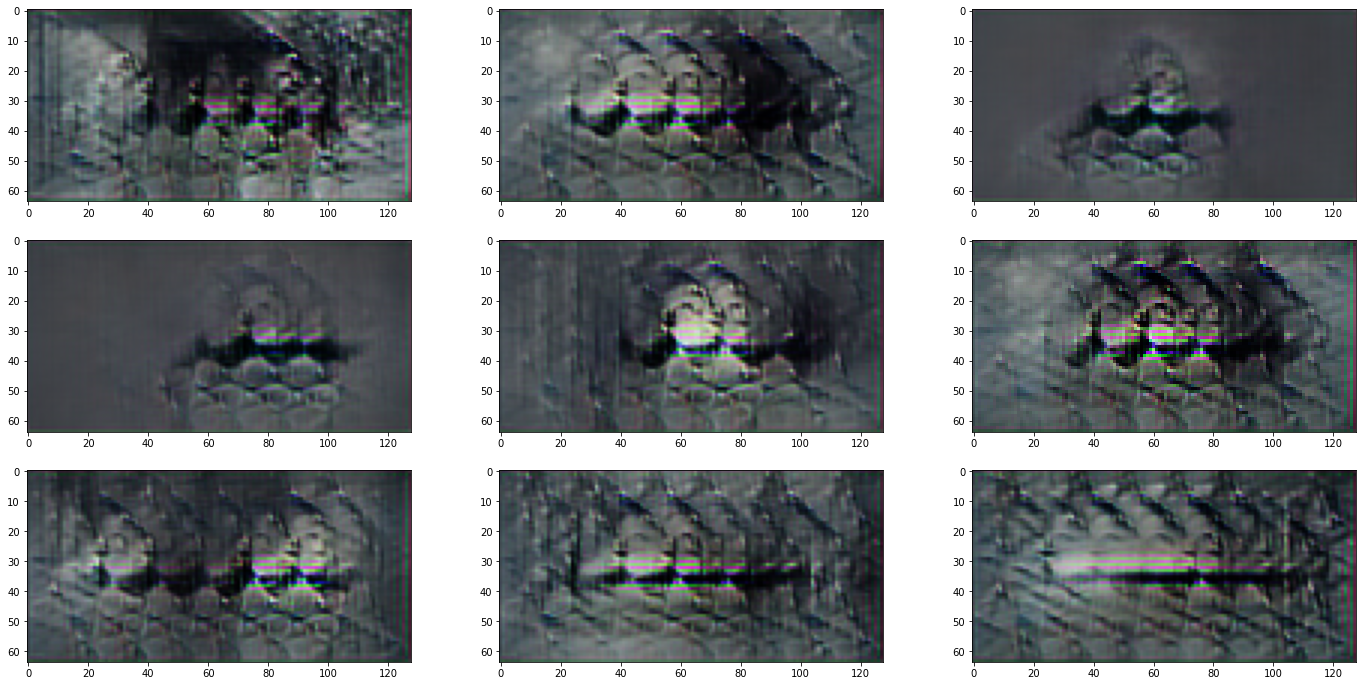

In [47]:
display_images(generated)
plt.show()

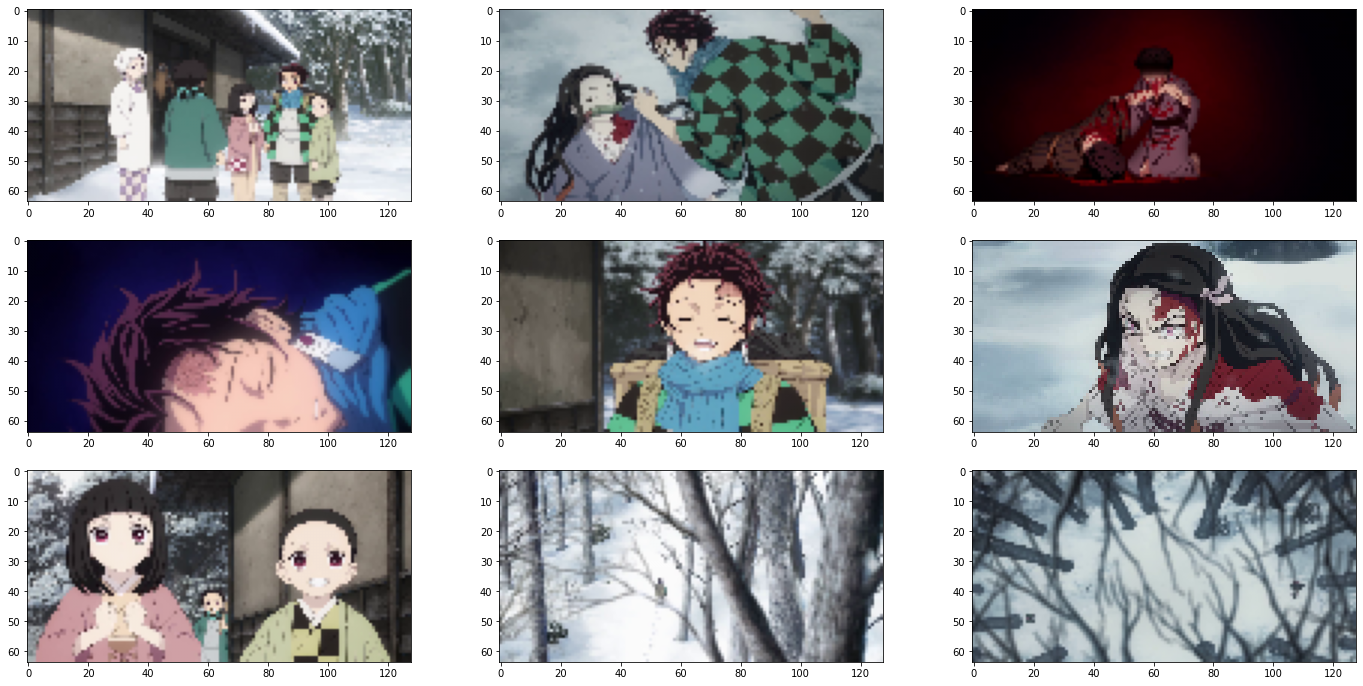

In [48]:
display_images(x)
plt.show()

In [52]:
x2 = train_ds[30][0]
generated2 = vqgan(x2[:10])

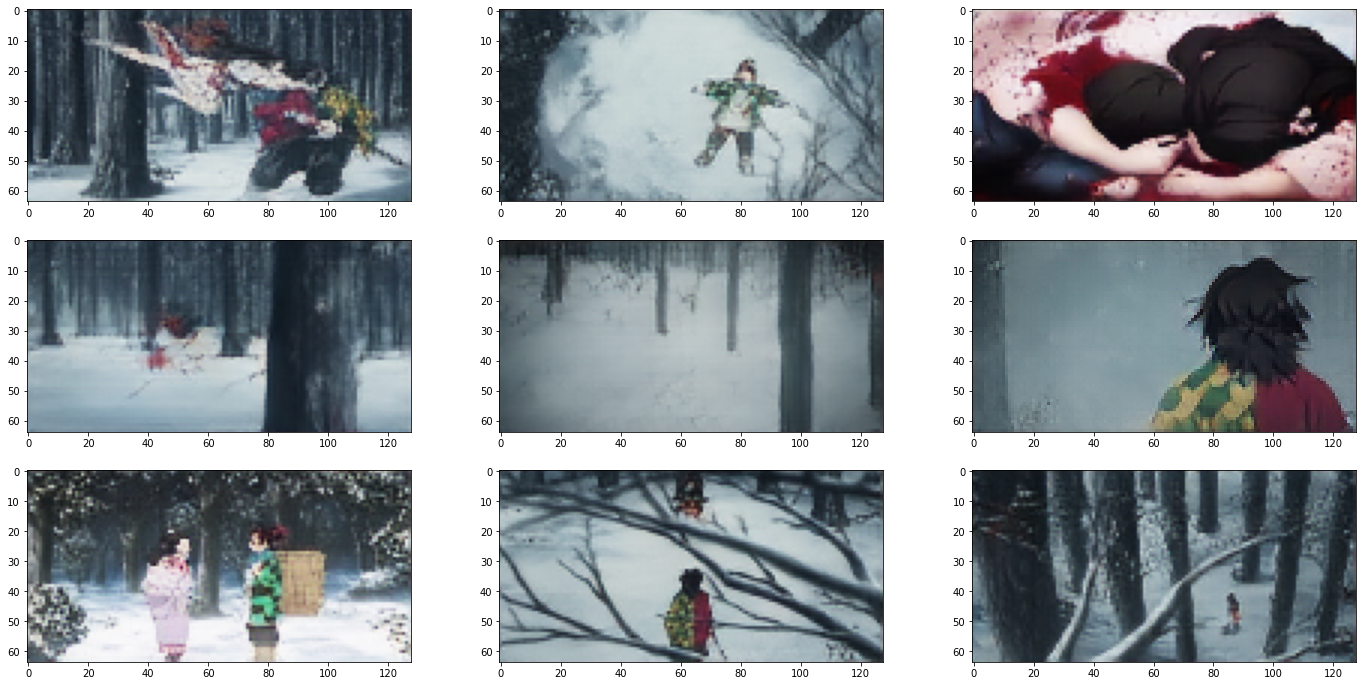

In [53]:
display_images(generated2)
plt.show()

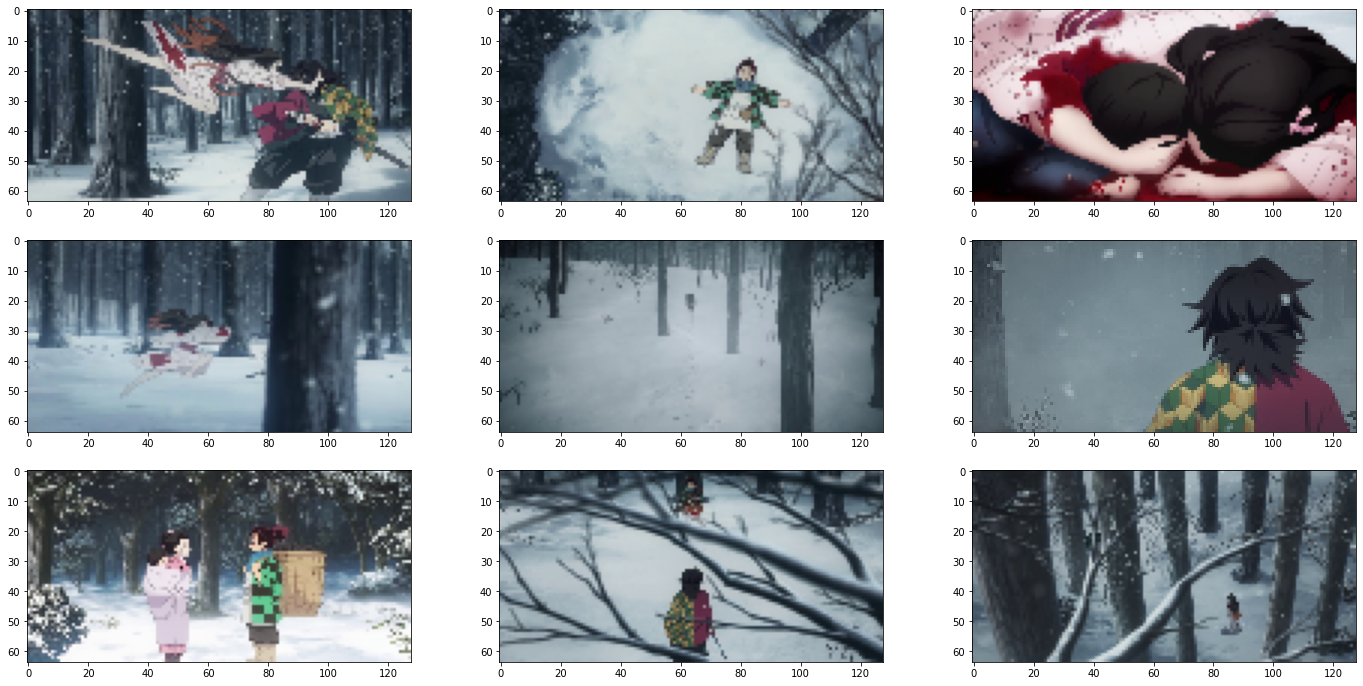

In [54]:
display_images(x2)
plt.show()

In [35]:
vqgan.save("../../../models/kny_discriminator_64x128")

INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Assets written to: ../../../models/kny_discriminator_64x128/assets


INFO:tensorflow:Assets written to: ../../../models/kny_discriminator_64x128/assets
